# Week 4: Interpretable Machine Learning for Data Science

**Problem**: You have been mandated by a large wine-making company in Valais to discover the key chemical factors that determine the quality of wine and build an interpretable model that will help their cellar masters make decisions daily.

## Settings things up (15')

This week will require quite a lot of autonomy on your part, but we will guide you with this high-level notebook. First, take the following steps:

- Install [Poetry](https://python-poetry.org). 
- Then use Poetry to create a virtual environment:

  ```sh
  poetry install
  ```

- Then restart VS Code and add the kernel that corresponds to the environment created by Poetry.

Then, let's set up [black](https://github.com/psf/black), which is a highly encouraged best-practice for all your Python projects. That way, you never have to worry and debate about code formatting anymore. By using it, you agree to cede control over minutiae of hand-formatting. In return, Black gives you speed, determinism, and freedom from `pycodestyle` nagging about formatting. You will save time and mental energy for more important matters.

Here are the libraries you will most likely need and use during this week:

- `numpy` for basic scientific computing and `scipy` for statistical testing.
- `pandas` or `polars` for dataset manipulation. Polars is highly recommended, because it is [awesome](https://github.com/ddotta/awesome-polars). Instructions below will refer to the Polars API.
- `seaborn` for statistical data visualization, but `matplotlib` is always needed anyway. Use both!
- `shap` will be used for [interpretability](https://shap.readthedocs.io/en/stable/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html).
- `sklearn` and `xgboost` will be used for training models. You may import them later when you need them.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import sklearn
import matplotlib.pyplot as plt

/home/lia/Desktop/HES/Semestre_5/ML/w4-isc-ml-Eteroclia/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Fetch the data (15')

Here we have a very nice package that can do everything for us (aka `ucimlrepo`). Let's use it!

Take a look at [the website](https://archive.ics.uci.edu/dataset/186/wine+quality) for details.

In [2]:
from ucimlrepo import list_available_datasets,fetch_ucirepo

# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
  



In [3]:
# metadata 
print(wine_quality.metadata) 
  
# variable information 
print(wine_quality.variables) 

{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

In [4]:
# data (as pandas dataframes) 

y = wine_quality.data.targets 
o = wine_quality.data.original

In [5]:
X=o.drop("quality", axis=1)

Now, let's check that the data have the correct shape to ensure they have been loaded as expected.

Calculate how many samples and features we have in total, how many are red or white wines, how many are good or bad wines, etc.

In [6]:
X.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000


In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  color                 6497 non-null   object 
dtypes: float64(11), object(1)
memory usage: 609.2+ KB


In [8]:
print(f"number of white wine: {X[X["color"]=="white"]["color"].count()}")

number of white wine: 4898


## Data Exploration (1h30)

We now will inspect the features one-by-one, and try to understand their dynamics, especially between white and red wines.

- Use `Dataframe.describe` to display statistics on each feature. Do the same for red wines only, and white wines only. Do you notice any clear difference?
- Compute the effect size by computing the [strictly standardized mean difference](https://en.wikipedia.org/wiki/Strictly_standardized_mean_difference) (SSMD) between the red and white wines for each feature. 

In [9]:
X_white=X[X["color"]=="white"].drop("color",axis=1)
X_white.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000


In [10]:
X_red=X[X["color"]=="red"].drop("color",axis=1)
X_red.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000


Now let's go a bit deeper into the same analysis, using more visual tools:

- For every feature, plot boxplots, violinplots or histograms for red and white wines. What can you infer? **If you feel a bit more adventurous**, plot the Cumulative Distribution Function (CDF) of the feature for white and red wines, and compute the [Kullback-Leibler divergence](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) (or entropy) between them. Explain why this might be useful.
- Plot the correlation matrix of all features as heatmaps, one for red and one for white wines. How do they differ? What can you infer?

<Axes: xlabel='color', ylabel='alcohol'>

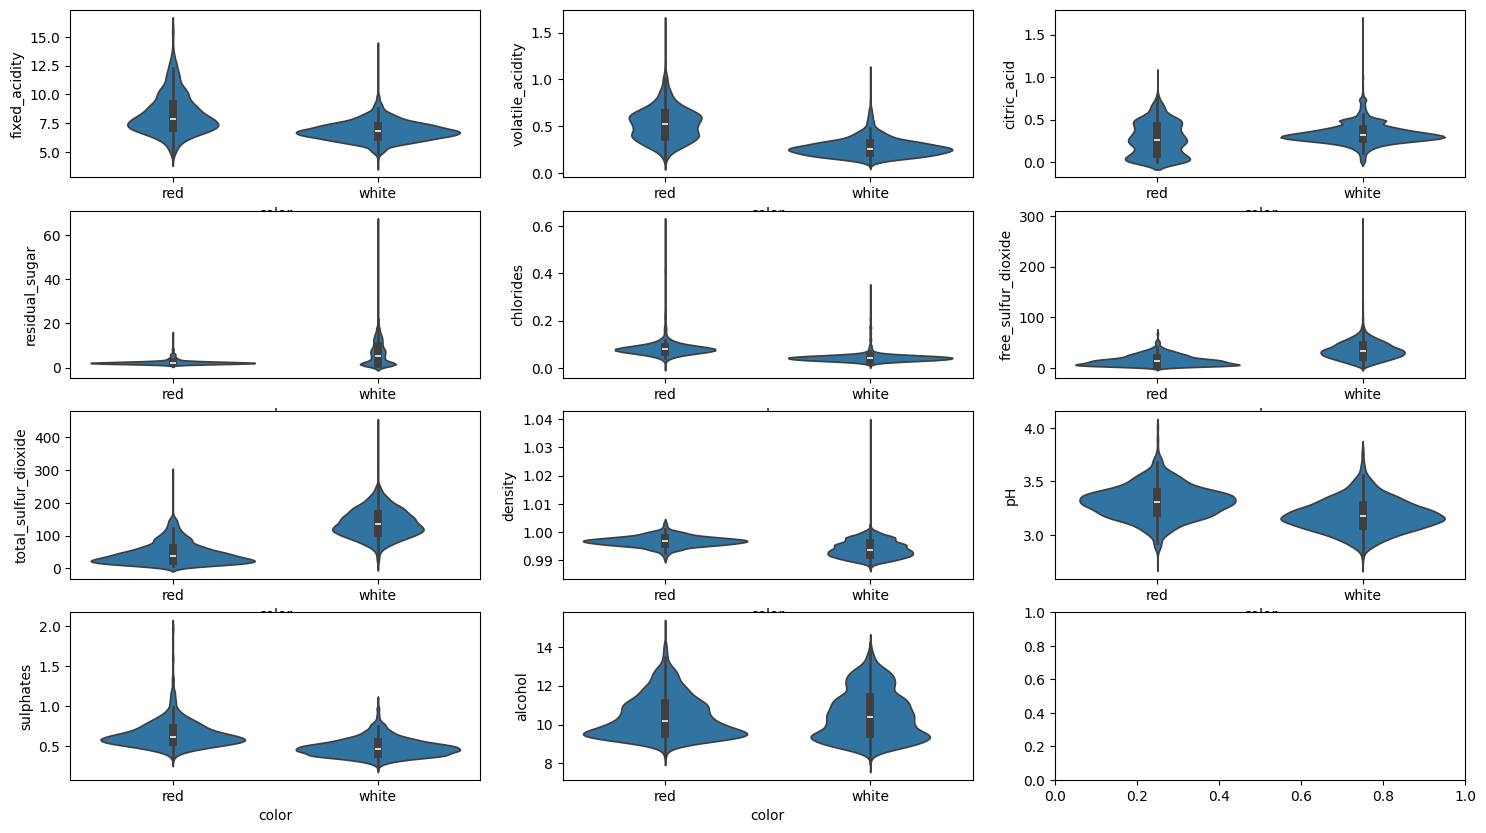

In [11]:
fig, axes = plt.subplots(4, 3, figsize=(18, 10))
# Create the violin plot
sns.violinplot(ax=axes[0, 0],x='color', y='fixed_acidity', data=X)
sns.violinplot(ax=axes[0, 1],x='color', y='volatile_acidity', data=X)
sns.violinplot(ax=axes[0, 2],x='color', y='citric_acid', data=X)
sns.violinplot(ax=axes[1, 0],x='color', y='residual_sugar', data=X)
sns.violinplot(ax=axes[1, 1],x='color', y='chlorides', data=X)
sns.violinplot(ax=axes[1, 2],x='color', y='free_sulfur_dioxide', data=X)
sns.violinplot(ax=axes[2, 0],x='color', y='total_sulfur_dioxide', data=X)
sns.violinplot(ax=axes[2, 1],x='color', y='density', data=X)
sns.violinplot(ax=axes[2, 2],x='color', y='pH', data=X)
sns.violinplot(ax=axes[3, 0],x='color', y='sulphates', data=X)
sns.violinplot(ax=axes[3, 1],x='color', y='alcohol', data=X)


# Display the plot
#plt.show()

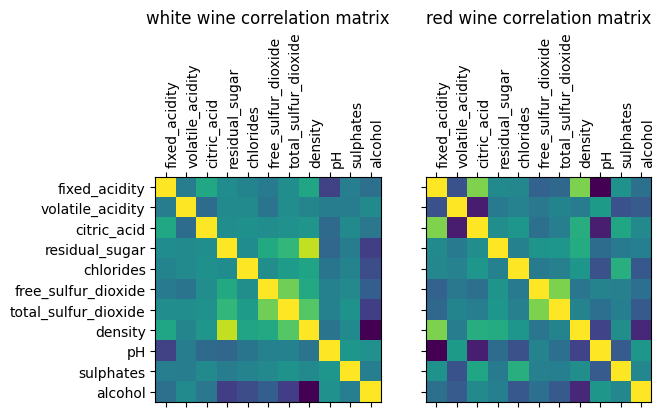

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2)


ax[0].matshow(X[X["color"]=="white"].drop("color",axis=1).corr(method='pearson'))

ax[0].set_xticks(labels=list(X.drop("color",axis=1)),ticks=range(0,11),rotation=90,ha="left")
ax[0].set_yticks(labels=list(X.drop("color",axis=1)),ticks=range(0,11))
ax[0].set_title("white wine correlation matrix")


ax[1].matshow(X[X["color"]=="red"].drop("color",axis=1).corr(method='pearson'))
ax[1].set_xticks(labels=list(X.drop("color",axis=1)),ticks=range(0,11),rotation=90,ha="left")
ax[1].set_yticks(labels=list(),ticks=range(0,11))
ax[1].set_title("red wine correlation matrix")

plt.show()


## Data Exploration using Unsupervised Learning (3h)

We first explore the data in an unsupervised fashion. Start by creating a heatmap of the average feature value for red and white wines. Can you spot an easy way to differentiate between reds and whites?

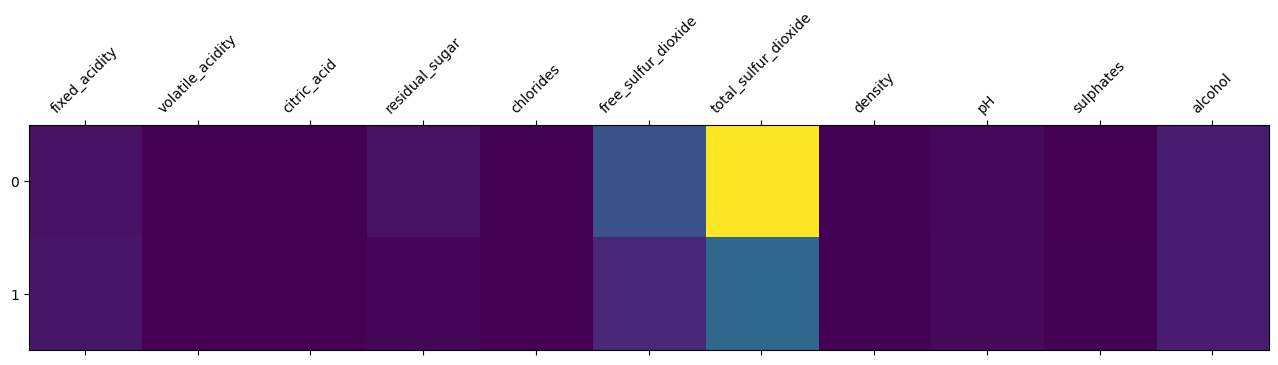

In [13]:
X_red_mean=X_red.mean()
X_white_mean=X_white.mean()
res=pd.DataFrame({"white":X_white_mean,"Red":X_red_mean})
plt.matshow(res.transpose())
plt.xticks(labels=list(X.drop("color",axis=1)),ticks=range(0,11),rotation=45)
plt.show()

In [14]:
from sklearn.preprocessing import RobustScaler


### Using PCA to reduce the dimensionality

Use PCA to reduce the dimensionality of data. Do not forget that it requires data normalization (centering on the mean and scaling to unit variance). Plot the whole dataset onto the two principal components and color it by wine color. What does it tell you?

Project the unit vectors that correspond to each vector onto the principal components, using the same transformation. What does it tell you about the relative feature importance? Does it match the observations you made previously?

In [15]:
scaler=RobustScaler()
labels=X["color"]
rescaled_X=pd.DataFrame(scaler.fit_transform(X.drop("color",axis=1)),columns=list(X)[:-1])
rescaled_X=rescaled_X.join(labels)
rescaled_X

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,color
0,0.307692,2.411765,-2.214286,-0.174603,1.074074,-0.750000,-1.063291,0.625806,1.428571,0.294118,-0.500000,red
1,0.615385,3.470588,-2.214286,-0.063492,1.888889,-0.166667,-0.645570,0.410753,-0.047619,1.000000,-0.277778,red
2,0.615385,2.764706,-1.928571,-0.111111,1.666667,-0.583333,-0.810127,0.453763,0.238095,0.823529,-0.277778,red
3,3.230769,-0.058824,1.785714,-0.174603,1.037037,-0.500000,-0.734177,0.668817,-0.238095,0.411765,-0.277778,red
4,0.307692,2.411765,-2.214286,-0.174603,1.074074,-0.750000,-1.063291,0.625806,1.428571,0.294118,-0.500000,red
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,-0.615385,-0.470588,-0.142857,-0.222222,-0.296296,-0.208333,-0.329114,-0.806452,0.285714,-0.058824,0.500000,white
6493,-0.307692,0.176471,0.357143,0.793651,0.000000,1.166667,0.632911,0.002151,-0.285714,-0.294118,-0.388889,white
6494,-0.384615,-0.294118,-0.857143,-0.285714,-0.222222,0.041667,-0.088608,-0.505376,-1.047619,-0.294118,-0.500000,white
6495,-1.153846,0.000000,-0.071429,-0.301587,-0.925926,-0.375000,-0.101266,-1.333333,0.619048,-0.764706,1.388889,white


In [16]:
import plotly.express as px
from sklearn.decomposition import PCA

In [17]:
"""fig = px.scatter_matrix(
    rescaled_X,
    dimensions=list(rescaled_X),
    color="color"
)
fig.update_traces(diagonal_visible=False)
fig.show()
"""


pca = PCA()
components = pca.fit_transform(rescaled_X[list(rescaled_X)[:-1]])
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(4),
    color=rescaled_X["color"],
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [18]:


pca = PCA(n_components=2)
components = pca.fit_transform(rescaled_X[list(rescaled_X)[:-1]])

fig = px.scatter(components, x=0, y=1, color=rescaled_X['color'])
fig.show()

### Cluster the data in 2-dimensional space

Use k-means to cluster the data into 2 clusters and plot the same view as before, but with a coloring that corresponds to the cluster memberships.

Assuming that the cluster assignments are predictions of a model, what is the performance you can achieve in terms of mutual information score, accuracy, and f1 score?

In [19]:
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_validate

In [20]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(components)
centers=kmeans.cluster_centers_

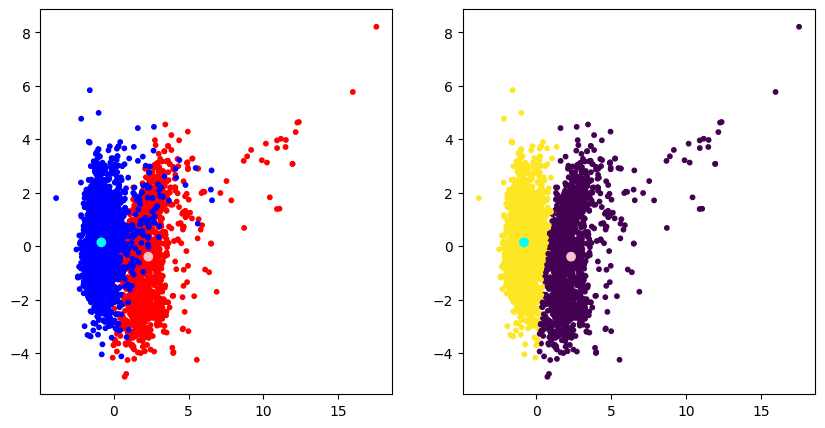

In [21]:
colors=list(map(lambda x : "Blue" if x=="white" else "Red",X["color"]))
figs, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(components[:,0],components[:,1],c=colors,s=10)
ax[0].scatter(centers[:,0],centers[:,1],c=["Pink","Cyan"])

ax[1].scatter(components[:,0],components[:,1],c=kmeans.predict(components),s=10)
ax[1].scatter(centers[:,0],centers[:,1],c=["Pink","Cyan"])
plt.show()


In [22]:
from sklearn.utils import shuffle

In [23]:
shuffled_X=shuffle(rescaled_X).reset_index(drop=True)
scores=cross_validate(kmeans, shuffled_X.drop("color",axis=1),shuffled_X["color"].map(lambda x: 1 if x=="red" else 0) , cv=10,scoring=["accuracy","f1_weighted","adjusted_mutual_info_score"])

print(scores["test_accuracy"])
print(scores["test_f1_weighted"])
print(scores["test_adjusted_mutual_info_score"])

[0.02307692 0.95846154 0.98307692 0.02769231 0.02615385 0.97230769
 0.97384615 0.02465331 0.96610169 0.03235747]
[0.02950851 0.95927737 0.98312203 0.03556469 0.03146279 0.97236363
 0.9740398  0.02914139 0.96648872 0.04149997]
[0.82173528 0.73302537 0.85759244 0.78479575 0.79409985 0.78294857
 0.79356443 0.80399984 0.74472469 0.77064681]


Now, we are going to train a **supervised** linear classification model using `sklearn`, and compare the results with the approach using clustering.

- Set up a train/test dataset using `sklearn.model_selection.train_test_split`.
- Use `GridSearchCV` to perform a cross-validation of the model's regularization `C`.
- Compare the test and train performance at the end. Does the model suffer from any overfitting? 
- Analyze the test performance specifically. What can you conclude about this general problem of recognizing white vs red wines?

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [25]:
test_set, train_set = train_test_split(shuffled_X)


In [26]:
reg=LogisticRegression()
gridValues={'C': [0.001,0.01,0.1,1,10,100,1000]}
grid_search = GridSearchCV(
                           estimator = reg,
                           param_grid = gridValues,
                           scoring = 'f1',
                           cv = 5,
                           )
grid_search.fit(test_set.drop("color",axis=1),test_set["color"].map(lambda x: 1 if x=="red" else 0))

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='f1')

In [27]:
print("train values:")
print(f"best c is {grid_search.best_estimator_}")
print(f"best score is {grid_search.best_score_}")

train values:
best c is LogisticRegression(C=100)
best score is 0.9882227353806682


In [28]:
predic_y=grid_search.best_estimator_.predict(test_set.drop("color",axis=1))

In [29]:
from sklearn.model_selection import LearningCurveDisplay

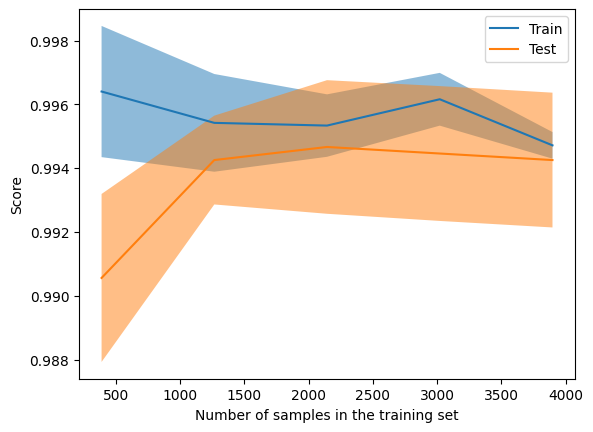

In [30]:
LearningCurveDisplay.from_estimator(grid_search.best_estimator_,test_set.drop("color",axis=1),test_set["color"].map(lambda x: 1 if x=="red" else 0))

In [31]:
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score,ConfusionMatrixDisplay


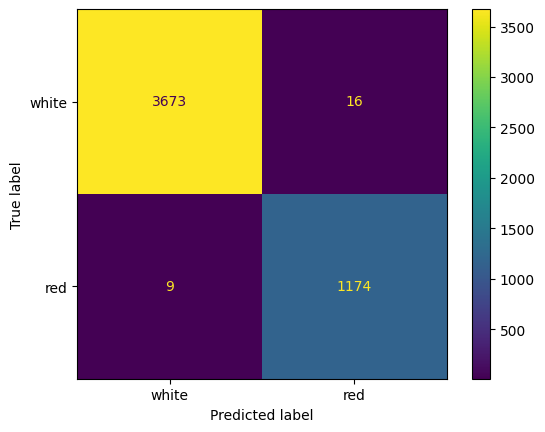

f1:0.989464812473662
accuracy:0.9948686371100164


In [32]:
conf_mat=confusion_matrix(predic_y,test_set["color"].map(lambda x: 1 if x=="red" else 0))
ConfusionMatrixDisplay(conf_mat,display_labels=["white","red"]).plot()
plt.show()
print(f"f1:{f1_score(predic_y,test_set["color"].map(lambda x: 1 if x=="red" else 0))}")
print(f"accuracy:{accuracy_score(predic_y,test_set["color"].map(lambda x: 1 if x=="red" else 0))}")

### Basic model interpretability: inspecting the model

As a first step towards intepretability of the model predictions, let's take a look at the coefficients of the model. What is the most important feature from this perspective? How do you interpret positive or negative coefficients?

Is it compatible with what you have seen so far? Do you have an explanation why that might be?

In [33]:
coefs=list(zip(list(X.drop("color",axis=1)),(grid_search.best_estimator_.coef_.flatten())))
#sns.swarmplot(data=coefs, x="importance", y="feature")
print(coefs)


[('fixed_acidity', np.float64(-1.2694232350796306)), ('volatile_acidity', np.float64(0.9129680914524161)), ('citric_acid', np.float64(-0.21786430808770782)), ('residual_sugar', np.float64(-6.666264864273696)), ('chlorides', np.float64(0.5385537802821726)), ('free_sulfur_dioxide', np.float64(1.6461563981277585)), ('total_sulfur_dioxide', np.float64(-4.111796852907889)), ('density', np.float64(11.56011274978313)), ('pH', np.float64(-0.9086421760194311)), ('sulphates', np.float64(0.22239124847994607)), ('alcohol', np.float64(5.11036279192343))]


### Removing features to test their importance

- What happens if you re-train a model, but remove the most important feature in the list?
- What happens if you re-train the model with a `l1` penalty and you use more regularization? 
- Interpret the results you obtained above from the perspective of the business problem. What does it tell you about the key differences between a red and white wine?

In [34]:
reg2=LogisticRegression()
gridValues={'C': [0.001,0.01,0.1,1,10,100,1000]}
grid_search_2 = GridSearchCV(
                           estimator = reg2,
                           param_grid = gridValues,
                           scoring = 'f1',
                           cv = 5,
                           )
grid_search_2.fit(test_set.drop(["color","density"],axis=1),test_set["color"].map(lambda x: 1 if x=="red" else 0))

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='f1')

In [35]:
print("train values:")
print(f"best c is {grid_search.best_estimator_}")
print(f"best score is {grid_search.best_score_}")

train values:
best c is LogisticRegression(C=100)
best score is 0.9882227353806682


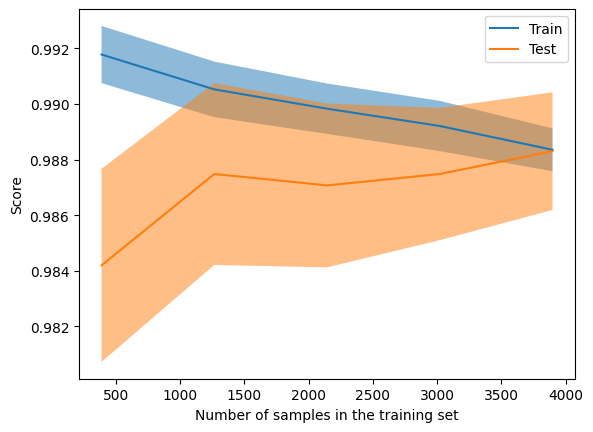

In [36]:
predic_y_2=grid_search_2.best_estimator_.predict(test_set.drop(["color","density"],axis=1))
LearningCurveDisplay.from_estimator(grid_search_2.best_estimator_,test_set.drop(["color","density"],axis=1),test_set["color"].map(lambda x: 1 if x=="red" else 0))

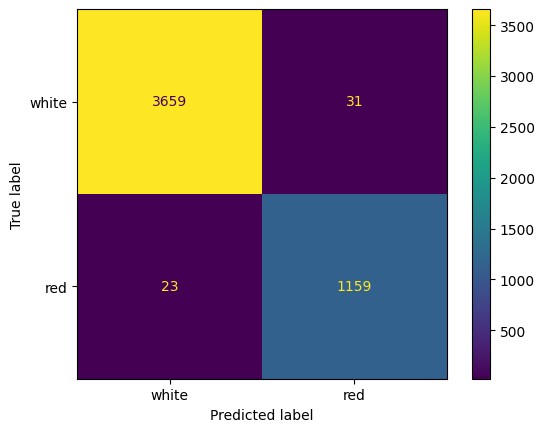

f1:0.9772344013490725
accuracy:0.9889162561576355


In [37]:
conf_mat_2=confusion_matrix(predic_y_2,test_set["color"].map(lambda x: 1 if x=="red" else 0))
ConfusionMatrixDisplay(conf_mat_2,display_labels=["white","red"]).plot()
plt.show()
print(f"f1:{f1_score(predic_y_2,test_set["color"].map(lambda x: 1 if x=="red" else 0))}")
print(f"accuracy:{accuracy_score(predic_y_2,test_set["color"].map(lambda x: 1 if x=="red" else 0))}")

### Using Shapley values

Now, use SHAP to explore how the model perceives a 'red' and 'white' wine.

- Use a `beeswarm` plot to analyze the influence of each feature on the model's output.
- What does the plot tell us about what makes a white wine 'white' and a red wine 'red'?

In [38]:
#sns.swarmplot(data=rescaled_X,x="color")
import shap
import xgboost


In [39]:
model = xgboost.XGBClassifier().fit(X.drop("color",axis=1),X["color"].map(lambda x: 1 if x=="red" else 0))

explainer=shap.Explainer(model,X.drop("color",axis=1))
shap_values=explainer(X.drop("color",axis=1))

 92%|==================  | 5994/6497 [00:11<00:00]       

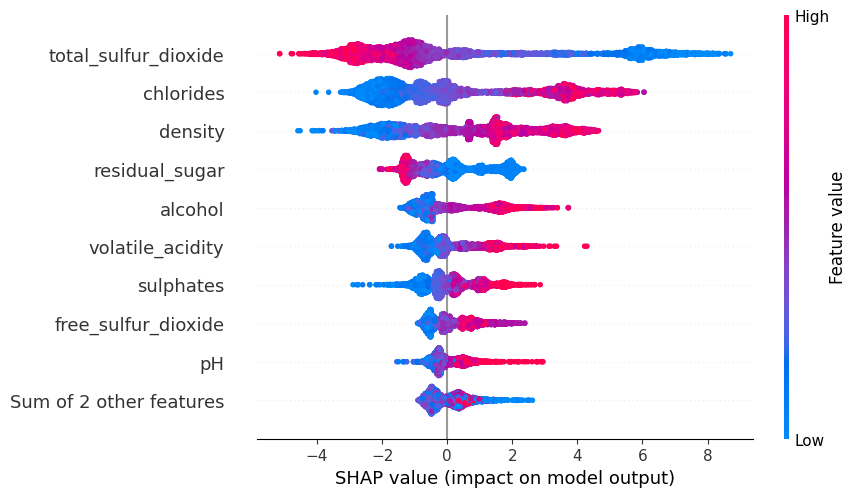

In [40]:
shap.plots.beeswarm(shap_values)

- Now use Partial Dependence Plots to see how the expected model output varies with the variation of each feature.

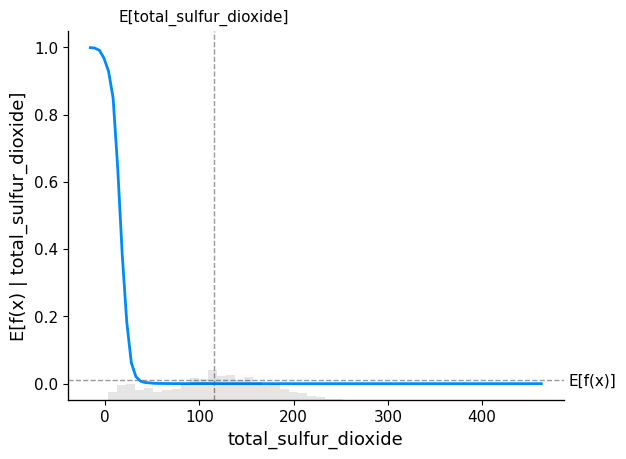

In [41]:

shap.partial_dependence_plot(
    "total_sulfur_dioxide",
    grid_search.best_estimator_.predict,
    X.drop("color",axis=1),
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

- Now use a waterfall diagram on a specific red and white wine and see how the model has made this specific prediction. 

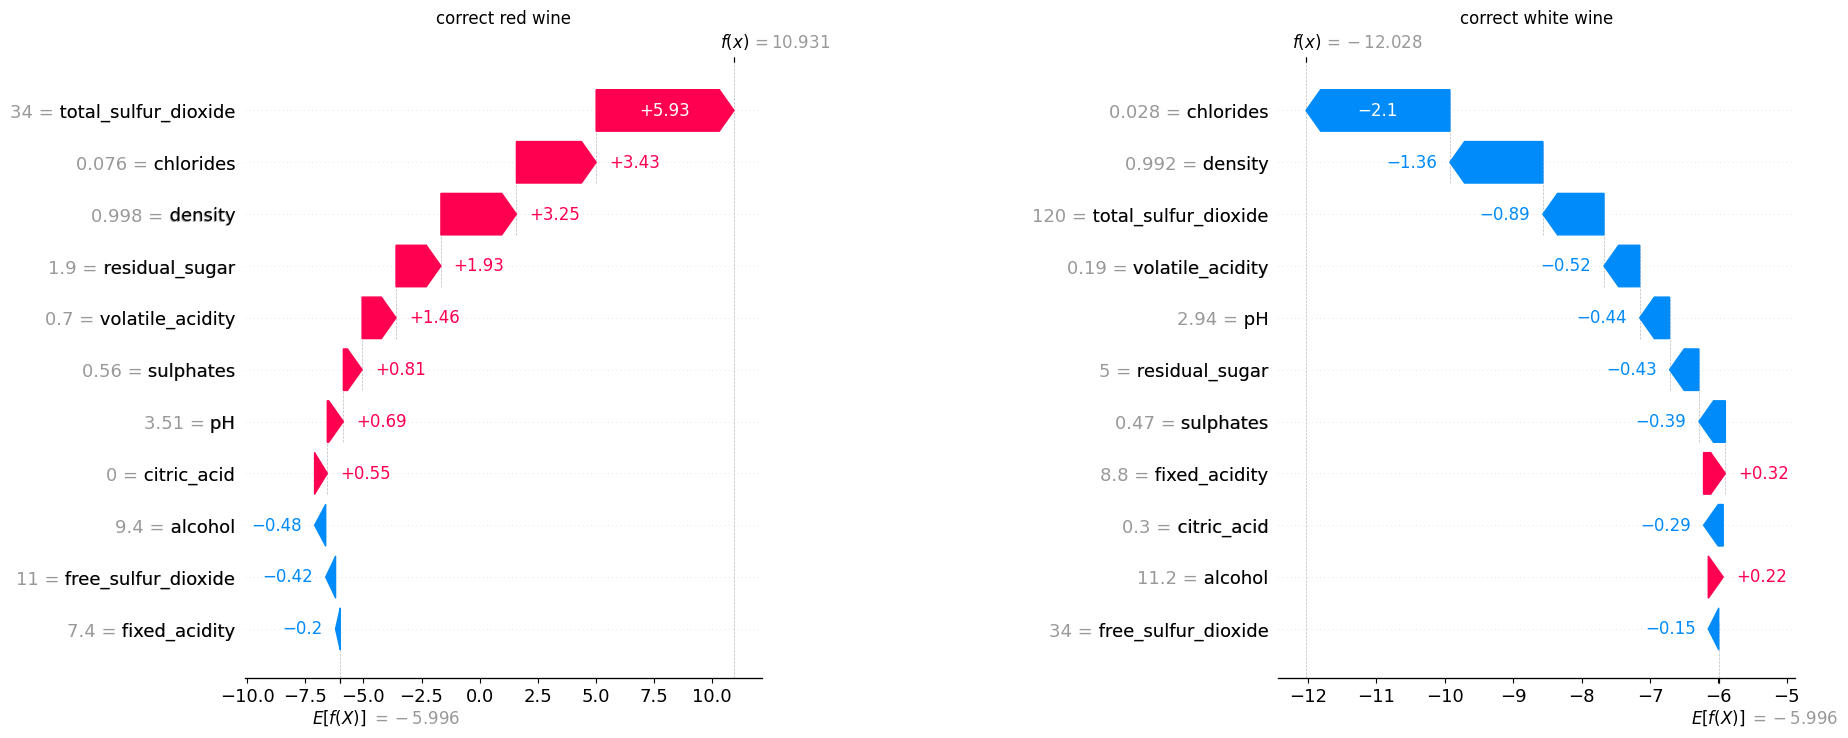

In [42]:
"""shap.plots.waterfall(shap_values[0], max_display=20,show=False)
plt.title("correct red wine")
plt.show()
shap.plots.waterfall(shap_values[5000], max_display=20,show=False)
plt.title("correct white wine")
plt.show()"""

figs, ax = plt.subplots(1,2,figsize=(10,5))
plt.sca(ax[0])
shap.plots.waterfall(shap_values[0], max_display=20,show=False)
ax[0].set_title("correct red wine")
plt.sca(ax[1])
shap.plots.waterfall(shap_values[5000], max_display=20,show=False)
ax[1].set_title("correct white wine")
plt.subplots_adjust(wspace=1)
figs.set_size_inches(20, 8)
plt.show()


- Now, let's take an example where the model has made an incorrect prediction, and see how it made this prediction.

In [43]:
error=[]
Y_color=list(test_set["color"].map(lambda x: 1 if x=="red" else 0))

for idx,res in enumerate(predic_y):
    if res!=Y_color[idx]:
        #print(res,Y_color[idx])
        error.append((idx,"red" if Y_color[idx] else "white"))
print(error)
print(len(error))

[(67, 'red'), (429, 'white'), (521, 'red'), (555, 'red'), (828, 'white'), (923, 'white'), (1242, 'red'), (1280, 'red'), (1974, 'white'), (2132, 'red'), (2388, 'red'), (2396, 'red'), (3027, 'white'), (3038, 'red'), (3055, 'white'), (3069, 'red'), (3217, 'red'), (3781, 'white'), (4123, 'red'), (4180, 'red'), (4468, 'red'), (4641, 'white'), (4642, 'red'), (4853, 'red'), (4857, 'white')]
25


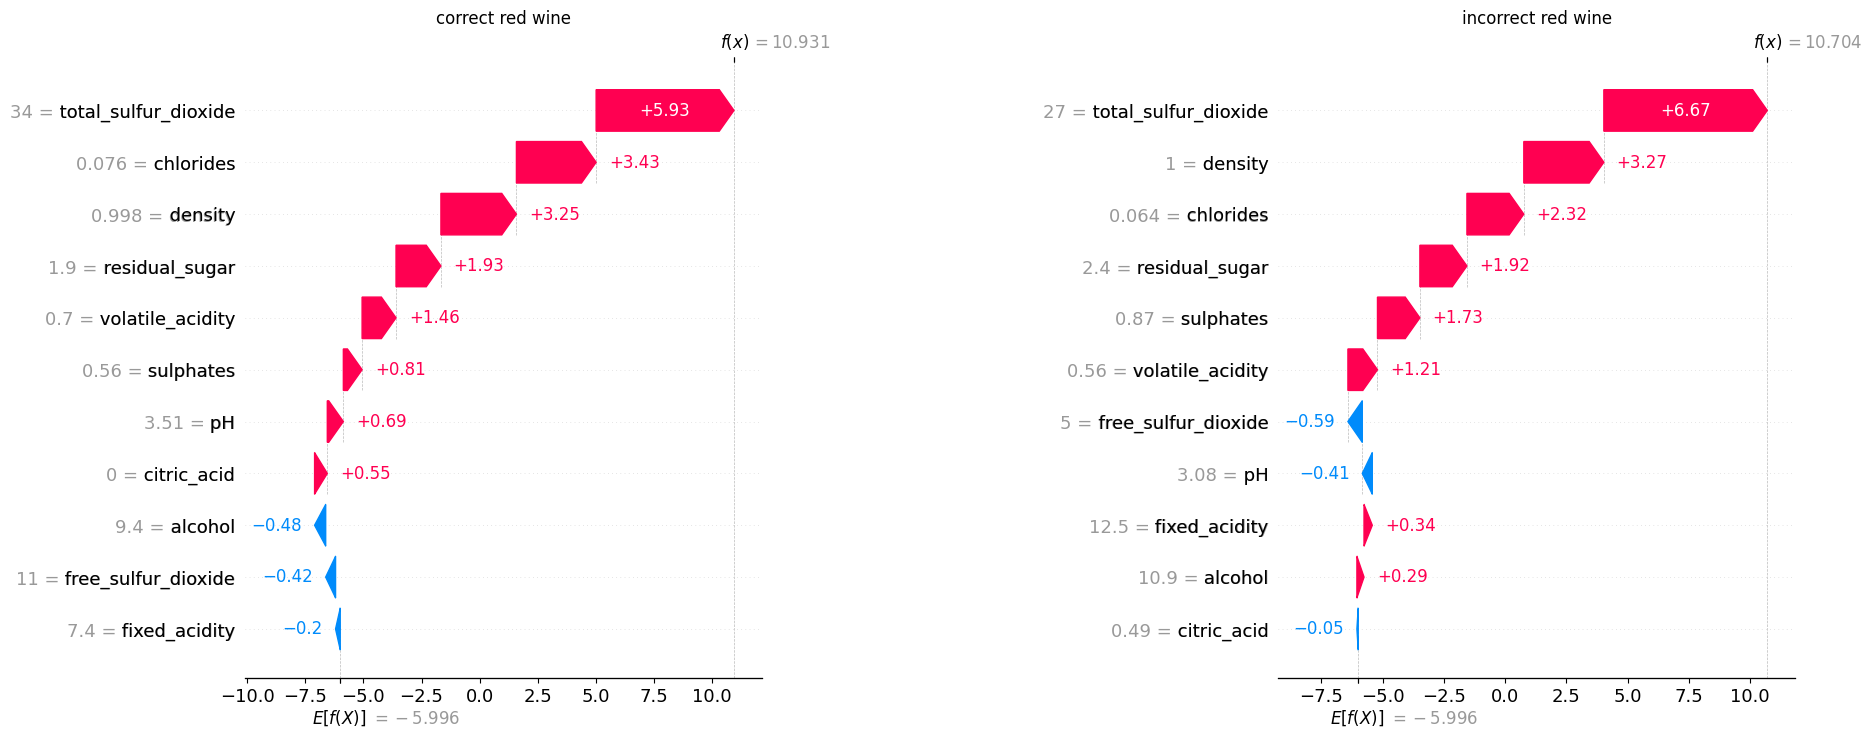

In [44]:
figs, ax = plt.subplots(1,2,figsize=(10,5))
plt.sca(ax[0])
shap.plots.waterfall(shap_values[0], max_display=20,show=False)
ax[0].set_title("correct red wine")
plt.sca(ax[1])
shap.plots.waterfall(shap_values[264], max_display=20,show=False)
ax[1].set_title("incorrect red wine")
plt.subplots_adjust(wspace=1)
figs.set_size_inches(20, 8)
plt.show()

# Good vs Bad classification (3h)

We are going to work on a binary classification problem, where all wines with a quality higher than 6 are considered as "good" and other are considered as "bad".  

- Prepare a dataset with a new column `binary_quality` that corresponds to the above definition.

In [45]:
binary_quality=y.map(lambda x : "good" if x>6 else "bad")
print(binary_quality)
X_resc_quality=rescaled_X.join(binary_quality)
print(X_resc_quality.head())

     quality
0        bad
1        bad
2        bad
3        bad
4        bad
...      ...
6492     bad
6493     bad
6494     bad
6495    good
6496     bad

[6497 rows x 1 columns]
   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0       0.307692          2.411765    -2.214286       -0.174603   1.074074   
1       0.615385          3.470588    -2.214286       -0.063492   1.888889   
2       0.615385          2.764706    -1.928571       -0.111111   1.666667   
3       3.230769         -0.058824     1.785714       -0.174603   1.037037   
4       0.307692          2.411765    -2.214286       -0.174603   1.074074   

   free_sulfur_dioxide  total_sulfur_dioxide   density        pH  sulphates  \
0            -0.750000             -1.063291  0.625806  1.428571   0.294118   
1            -0.166667             -0.645570  0.410753 -0.047619   1.000000   
2            -0.583333             -0.810127  0.453763  0.238095   0.823529   
3            -0.500000            

One question that we might ask right away is:

- Is there any correlation of the quality and the color of the wine? 

Ideally, there should be almost none. Why could it be a problem otherwise?

In [46]:
list(X_resc_quality)

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'residual_sugar',
 'chlorides',
 'free_sulfur_dioxide',
 'total_sulfur_dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'color',
 'quality']

In [47]:



red=X_resc_quality[X["color"]=="red"]
white=X_resc_quality[X["color"]=="white"]

print(f"number of bad white wine: {white[white["quality"]=="bad"]["quality"].count()} out of {white["quality"].count()}, or {white[white["quality"]=="bad"]["quality"].count()/white["quality"].count()*100}%")
print(f"number of bad red wine: {red[red["quality"]=="bad"]["quality"].count()} out of {red["quality"].count()}, or {red[red["quality"]=="bad"]["quality"].count()/red["quality"].count()*100}%")

number of bad white wine: 3838 out of 4898, or 78.35851367905268%
number of bad red wine: 1382 out of 1599, or 86.42901813633522%


If it turns out that there are significantly more bad red wines than bad white wines or vice versa, what are the implications for your analysis?

- Plot a heatmap of the mean feature value for bad and good wines, like we did before for red and white wines.
- Plot two heatmaps, one for red and white wines. How do they differ? What kind of issue can it cause?

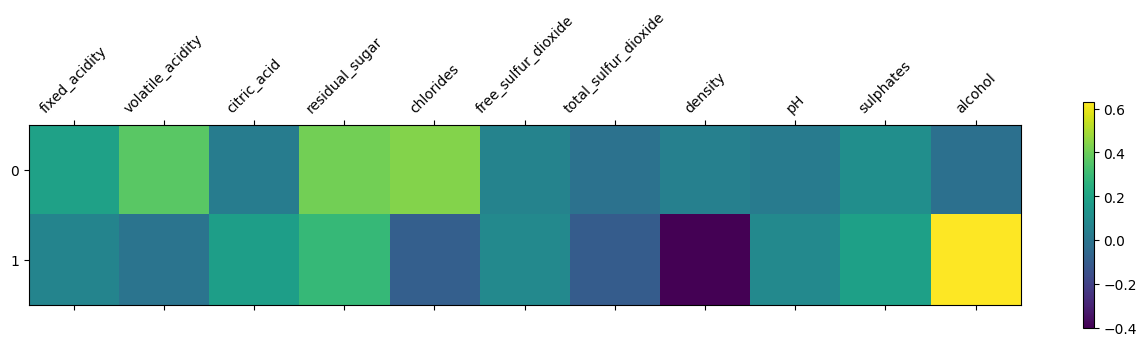

In [48]:
X_bad_mean=X_resc_quality[X_resc_quality["quality"]=="bad"].drop(["quality","color"],axis=1).mean()
X_good_mean=X_resc_quality[X_resc_quality["quality"]=="good"].drop(["quality","color"],axis=1).mean()
res2=pd.DataFrame({"bad":X_bad_mean,"good":X_good_mean})
plt.matshow(res2.transpose())
plt.xticks(labels=list(X.drop("color",axis=1)),ticks=range(0,11),rotation=45)
plt.colorbar()
plt.show()

It is a lot more difficult now to tell apart good from bad wines. Let's turn to a more complex model, which is a [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting) [Trees](https://xgboost.readthedocs.io/en/stable/tutorials/model.html). For the sake of interpretability, design your notebook so that you can easily filter on only white and red wines and perform again the entire procedure.

Let's first train a XGBClassifier model to distinguish between good and bad wines. Make sure to use the same best-practices (train/test split, cross-validation) as we did before. Note that the regularization of the GBTs is a lot more complex than for Logistic Regression. Test the following parameters:

  ```py
  param_grid = {
    "max_depth": [3, 4, 5],  # Focus on shallow trees to reduce complexity
    "learning_rate": [0.01, 0.05, 0.1],  # Slower learning rates
    "n_estimators": [50, 100],  # More trees but keep it reasonable
    "min_child_weight": [1, 3],  # Regularization to control split thresholds
    "subsample": [0.7, 0.9],  # Sampling rate for boosting
    "colsample_bytree": [0.7, 1.0],  # Sampling rate for columns
    "gamma": [0, 0.1],  # Regularization to penalize complex trees
  }
  ```

In [53]:
from xgboost import XGBClassifier


In [59]:
train_set_2 , test_set_2= train_test_split(X_resc_quality)

In [61]:
gbc=XGBClassifier()
param_grid = {
    "max_depth": [3, 4, 5],  # Focus on shallow trees to reduce complexity
    "learning_rate": [0.01, 0.05, 0.1],  # Slower learning rates
    "n_estimators": [50, 100],  # More trees but keep it reasonable
    "min_child_weight": [1, 3],  # Regularization to control split thresholds
    "subsample": [0.7, 0.9],  # Sampling rate for boosting
    "colsample_bytree": [0.7, 1.0],  # Sampling rate for columns
    "gamma": [0, 0.1],  # Regularization to penalize complex trees
  }
transformed_df=train_set_2.drop(["quality","color"],axis=1).join(train_set_2["color"].map(lambda x: 1 if x=="red" else 0))
grid_search_3 = GridSearchCV(
                           estimator = gbc,
                           param_grid = param_grid,
                           scoring = 'f1',
                           cv = 5,
                           n_jobs=4,
                           )
grid_search_3.fit(transformed_df,train_set_2["quality"].map(lambda x: 1 if x=="good" else 0))

/home/lia/Desktop/HES/Semestre_5/ML/w4-isc-ml-Eteroclia/venv/lib/python3.12/site-packages/numpy/ma/core.py:2846: RuntimeWarning:

invalid value encountered in cast



GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.7, 1.0], 'gamma': [0, 0.1],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1, 3],
                         'n_estimators': [50, 100], 'subsample': [0.7, 0.9]},
             scoring='f1')

- Analyze the results (test and train), validate whether there is overfitting.

In [72]:
print("train values:")
print(f"best parameters are {grid_search_3.best_estimator_}")
print(f"best score (f1) is {grid_search_3.best_score_}")

train values:
best parameters are XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
best score (f1) is 0.5800752670714681


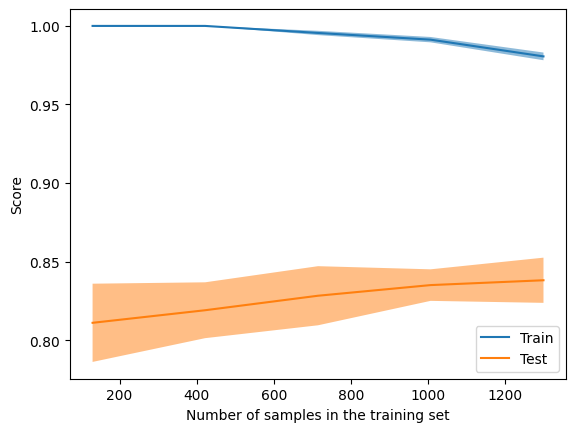

In [70]:
transformed_df_test=test_set_2.drop(["quality","color"],axis=1).join(test_set_2["color"].map(lambda x: 1 if x=="red" else 0))
predic_y_3=grid_search_3.best_estimator_.predict(transformed_df_test)
LearningCurveDisplay.from_estimator(grid_search_3.best_estimator_,transformed_df_test,test_set_2["quality"].map(lambda x: 1 if x=="good" else 0))
plt.show()

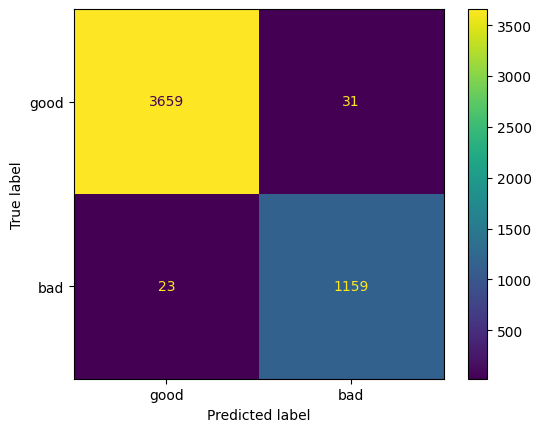

f1:0.5601503759398496
accuracy:0.856


In [71]:
conf_mat_3=confusion_matrix(predic_y_3,test_set_2["quality"].map(lambda x: 1 if x=="good" else 0))
ConfusionMatrixDisplay(conf_mat_2,display_labels=["good","bad"]).plot()
plt.show()
print(f"f1:{f1_score(predic_y_3,test_set_2["quality"].map(lambda x: 1 if x=="good" else 0))}")
print(f"accuracy:{accuracy_score(predic_y_3,test_set_2["quality"].map(lambda x: 1 if x=="good" else 0))}")

In [73]:
explainer=shap.Explainer(grid_search_3.best_estimator_,transformed_df)
shap_values=explainer(transformed_df)

 96%|=================== | 4692/4872 [00:14<00:00]       

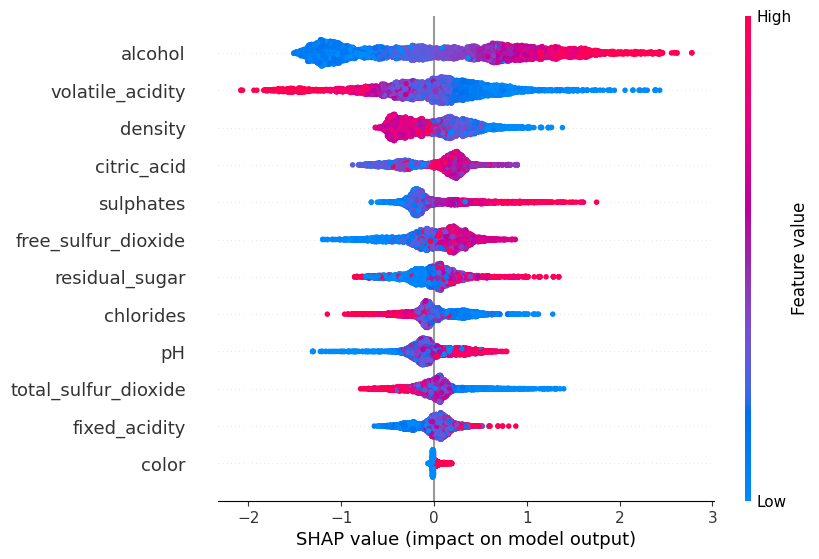

In [75]:
shap.plots.beeswarm(shap_values,max_display=20)

## Interpretability with SHAP (2h)

- Plot the feature importance (gain and cover) from the XGBoost model. What can you conclude?

In [47]:
# Complete this cell with your code

- Use SHAP's `TreeExplainer` to compute feature importance (Shapley values). Do you see any difference with XGBoost's feature importances?
- Produce different plots to analyze Shapley values: 
  - A bar plot that summarizes the mean absolute value of each feature.
  - A beeswarm plot that shows the shapley value for every sample and every feature.
  - A [heatmap plot](https://shap.readthedocs.io/en/stable/example_notebooks/api_examples/plots/heatmap.html#heatmap-plot) that indicates how different feature patterns influence the model's output.
- Based on the above results, what makes a wine 'good' or 'bad'?

In [48]:
# Complete this cell with your code

- Now use Partial Dependence Plots to see how the expected model output varies with the variation of each feature.
- How does that modify your perspective on what makes a good or bad wine?

In [49]:
# Complete this cell with your code

- Search for literature or resources that provide indications of the chemical structure of good or poor wines. Do your findings match these resources? 

### Analyze a few bad wines, and try to see how to make them better

Pick some of the worst wines, and try to see what make them so bad. Check out [`shap.plots.heatmap`](https://shap.readthedocs.io/en/stable/example_notebooks/api_examples/plots/heatmap.html#heatmap-plot) for some visual tool to do this.

How would you go about improving them?

In [50]:
# Complete this cell with your code

# Wrap-up and conclusion

As wrap-up, explain what are your key findings, and make 3 recommendations to the wine maker on how to improve the wines for next year. How confident are you that making these changes will lead to better wines? Explain in simple terms to the winemaker the limitations of your approach in terms of capturing causality.